# Bibliotecas

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, ElasticNet, ElasticNetCV, LassoCV, Ridge, RidgeCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import mean_squared_error,r2_score, median_absolute_error
from sklearn.svm import SVR, LinearSVR, LinearSVC
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from yellowbrick.regressor import ManualAlphaSelection, PredictionError, ResidualsPlot, PredictionError, residuals_plot, ResidualsPlot, AlphaSelection
from yellowbrick.regressor.alphas import alphas
from yellowbrick.model_selection import RFECV, ValidationCurve, LearningCurve, FeatureImportances
from yellowbrick.target import FeatureCorrelation
from yellowbrick.features import JointPlotVisualizer
from tpot import TPOTRegressor
import shap
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

from imblearn.over_sampling import ADASYN, RandomOverSampler

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold

In [74]:
def split(x,y,size):
    return train_test_split(x, y, test_size=size, random_state=42)

In [75]:
def models(model,x,x_val,y,y_val):
    model.fit(x,y)
    y_pred = model.predict(x_val)
    residuo(model, x, x_val, y, y_val)
    metrics(model,y_val, y_pred)

In [76]:
def metrics(model,y_val, y_pred):
    print('MSE: {}, MAE: {}, R2: {}'.format(mean_squared_error(y_val,y_pred), median_absolute_error(y_val, y_pred), r2_score(y_val, y_pred)))

In [77]:
def feat_importances(train,y):
    model = RandomForestRegressor()
    model.fit(train,y)
    feat_importances = pd.Series(model.feature_importances_, index= train.columns)
    return feat_importances.nlargest(20).plot(kind='barh',color='#75bbfd')

In [78]:
def feature_importance(model,X_train,y_train):
    plt.figure(figsize=(10,10))
    labels = list(map(lambda s: s.title(), X_train.columns))
    viz = FeatureImportances(model, labels=labels, relative=False, colormap='BrBG')
    viz.fit(X_train, y_train)
    return viz.show()

In [79]:
def residuo(model,X_train,X_test,y_train,y_test):
    plt.figure(figsize=(9,6))
    visualizer = ResidualsPlot(model,hist=True)
    visualizer.fit(X_train.squeeze(), y_train.squeeze().astype('float'))  # Fit the training data to the visualizer
    visualizer.score(X_test.squeeze(), y_test.squeeze().astype('float'))  # Evaluate the model on the test data
    return visualizer.show()

In [80]:
def tpot(X_train,X_test,y_train,y_test,nome):
    pipeline_optimizer = TPOTRegressor(generations=5, population_size=50, cv=2, random_state=42, verbosity=2)
    pipeline_optimizer.fit(X_train, y_train)
    predict=pipeline_optimizer.predict(X_test)
    pipeline_optimizer.export(nome)
    return (print(pipeline_optimizer.score(X_test, y_test)),"\n",metric(y_test,predict))

In [81]:
def learning (model, X_train, y_train):
    visualizer = LearningCurve(model, scoring='r2')
    visualizer.fit(X_train, y_train.squeeze())       
    visualizer.show() 

In [82]:
def preprocess(df):
    x = df.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df = pd.DataFrame(x_scaled)
    return df

In [83]:
def linear_coef(model,X_train):
    intercept = model.intercept_
    features = pd.DataFrame(model.coef_, X_train.columns, columns=['coefficient'])
    features.coefficient = features.coefficient.abs()
    stdevs = []
    for i in X_train.columns:
        stdev = df[i].std()
        stdevs.append(stdev)

    features["stdev"] = np.array(stdevs).reshape(-1,1)
    features["importance"] = features["coefficient"] * features["stdev"]
    features['importance_normalized'] = 100*features['importance'] / features['importance'].max()
    plt.figure(figsize=(12,10))
    plt.barh(features.index, features.importance_normalized)

In [84]:
def error(model, X_train, X_val, y_train, y_val):
    visualizer = PredictionError(model,shared_limits=False)
    visualizer.fit(X_train, y_train.astype('float'))  # Fit the training data to the visualizer
    visualizer.score(X_val, y_val.astype('float'))  # Evaluate the model on the test data
    visualizer.show()                 # Finalize and render the figure

In [85]:
df = pd.read_csv('data/preprocess.csv')
notas = pd.read_csv('data/notas_candidatos.csv')

In [86]:
df_merge = pd.merge(df,notas,how='left',on='nome')

## Modelagem para Nota Final

In [87]:
df_teste = df_merge[df_merge['aprovado'] =='?']

In [88]:
df_train = df_merge[df_merge['aprovado'] !='?']
X = df_train.drop(df_train.filter(regex='nota').columns,axis=1)
X = X.drop(['nome','id_candidato','aprovado'],axis=1)
y = df_train['nota_Final']

A regularização L1 produz modelos com menos parâmetros diferentes de zero, realizando efetivamente a seleção de recursos implícitos, o que poderia ser desejável para explicabilidade do desempenho na produção, enquanto a regularização L2 produz modelos com parâmetros mais conservadores (mais próximos de zero) e é efetivamente semelhante a ter um zero forte prévios centrados para os parâmetros (no mundo bayesiano). L2 é geralmente melhor para a precisão da previsão do que L1.

Porque ElasticNet?

**Baseline com ElasticNet**

In [89]:
X_base = X

In [90]:
for col in X:
    X_base[col] = X_base[col].astype('category')

In [91]:
X_base = X_base.drop('idade',axis=1)

In [92]:
X_base = preprocess(X_base)

In [93]:
X_train_base, X_val_base, y_train_base, y_val_base = split(X_base, y,0.2)

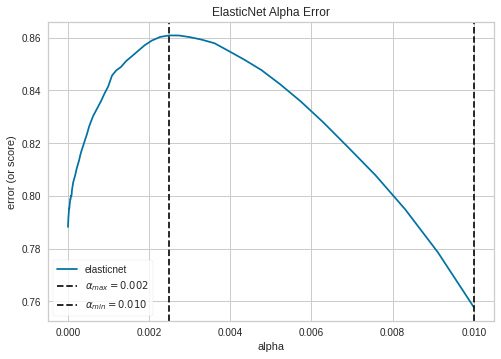

ManualAlphaSelection(alphas=array([1.00000000e-10, 1.09698580e-10, 1.20337784e-10, 1.32008840e-10,
       1.44811823e-10, 1.58856513e-10, 1.74263339e-10, 1.91164408e-10,
       2.09704640e-10, 2.30043012e-10, 2.52353917e-10, 2.76828663e-10,
       3.03677112e-10, 3.33129479e-10, 3.65438307e-10, 4.00880633e-10,
       4.39760361e-10, 4.82410870e-10, 5.29197874e-10, 5.80522552e-10,
       6.36824994e-10,...
       1.72258597e-03, 1.88965234e-03, 2.07292178e-03, 2.27396575e-03,
       2.49450814e-03, 2.73644000e-03, 3.00183581e-03, 3.29297126e-03,
       3.61234270e-03, 3.96268864e-03, 4.34701316e-03, 4.76861170e-03,
       5.23109931e-03, 5.73844165e-03, 6.29498899e-03, 6.90551352e-03,
       7.57525026e-03, 8.30994195e-03, 9.11588830e-03, 1.00000000e-02]),
                     ax=<AxesSubplot:title={'center':'ElasticNet Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>,
                     model=None)

In [94]:
from yellowbrick.regressor.alphas import manual_alphas

# Instantiate a model
model = ElasticNet(tol=0.01, max_iter=10000)

# Use the quick method and immediately show the figure
manual_alphas(model, X_train_base, y_train_base, cv=6)

In [95]:
model = ElasticNet(alpha=0.005, tol=0.01, max_iter=10000)

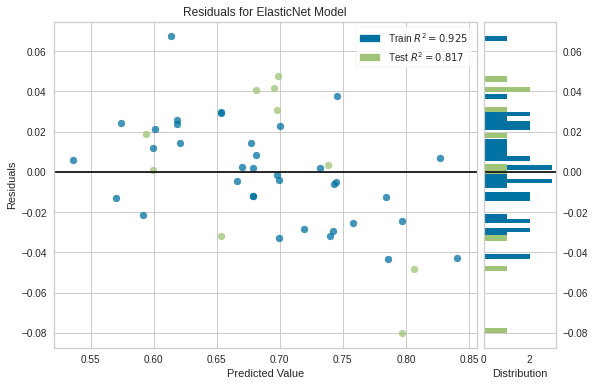

MSE: 0.0016694416755406213, MAE: 0.03624734323036288, R2: 0.8174983732165944


In [96]:
models(model, X_train_base, X_val_base, y_train_base, y_val_base)

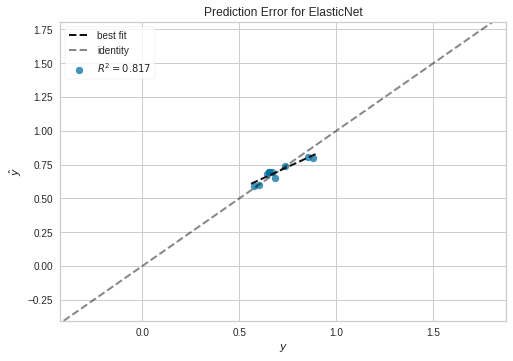

In [97]:
error(model, X_train_base, X_val_base, y_train_base, y_val_base)

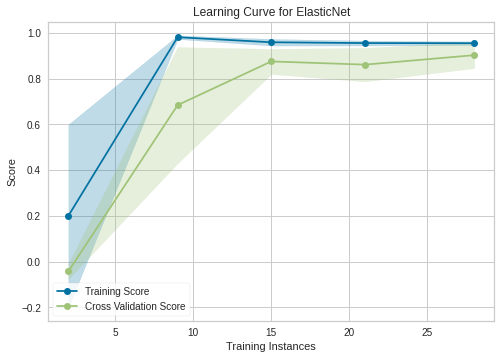

In [113]:
learning(model,X_train,y_train)
plt.show()

*Diario para base*

1 - 0.857 (com idade)

2 - 0.857 (com idade e category)

3 - 0.868 (sem idade e category)

4 - 0.868 (sem idade)

5 - 0.817 (preprocess e sem idade)

**SelectKbest**

In [199]:
X_train, X_val, y_train, y_val = split(X, y,0.2)

In [100]:
k_vs_score=[]

for k in range(2,55,1):
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new2 = selector.fit_transform(X_train,y_train.astype('float'))
    X_val2 = selector.transform(X_val)
    mdl = Ridge()
    mdl.fit(X_new2,y_train)
    p=mdl.predict(X_val2)
    score= metrics(mdl,y_val,p)
    print('k = {} '.format(k))
    
    k_vs_score.append(score)

MSE: 0.006382563965259125, MAE: 0.06966804807447685, R2: 0.302264748882752
k = 2 
MSE: 0.006386418321118785, MAE: 0.06952167165391321, R2: 0.30184339471093746
k = 3 
MSE: 0.0018439094944143236, MAE: 0.023645428316739048, R2: 0.7984257328049477
k = 4 
MSE: 0.0018084148785926335, MAE: 0.023276023147400404, R2: 0.8023059672716071
k = 5 
MSE: 0.0017966709775006063, MAE: 0.023149920329072093, R2: 0.8035897983185254
k = 6 
MSE: 0.0017908178126345316, MAE: 0.02308629733101386, R2: 0.8042296602110016
k = 7 
MSE: 0.0017873122422604893, MAE: 0.02304793863034338, R2: 0.8046128855164675
k = 8 
MSE: 0.0017849779072447373, MAE: 0.023022288653771428, R2: 0.8048680725913284
k = 9 
MSE: 0.001783311877278183, MAE: 0.023003929130046008, R2: 0.8050502012536356
k = 10 
MSE: 0.0017820631035081742, MAE: 0.022990138587871134, R2: 0.8051867159027246
k = 11 
MSE: 0.0017810922827711574, MAE: 0.022979400200729583, R2: 0.8052928450154793
k = 12 
MSE: 0.001780315910252954, MAE: 0.02297080166056653, R2: 0.8053777172

In [101]:
k=6
selector6 = SelectKBest(score_func= f_regression, k=k)
X_new = selector6.fit_transform(X_train, y_train.astype('float'))
X_train.loc[:, selector6.get_support()].columns

Index(['algoritmo_otimizacao', 'algoritmo_sist_sugestao', 'algoritmo_robotica',
       'ingles_leitura', 'ingles_escrita', 'ingles_conversa'],
      dtype='object')

**Feature selection com LASSO**

In [495]:
X_lasso = X

In [496]:
for col in X:
    X_lasso[col] = X_lasso[col].astype('category')

In [497]:
X_lasso = X_lasso.drop('idade',axis=1)

In [498]:
X_lasso = preprocess(X_lasso)

In [499]:
X_train, X_val, y_train, y_val = split(X_lasso, y,0.2)

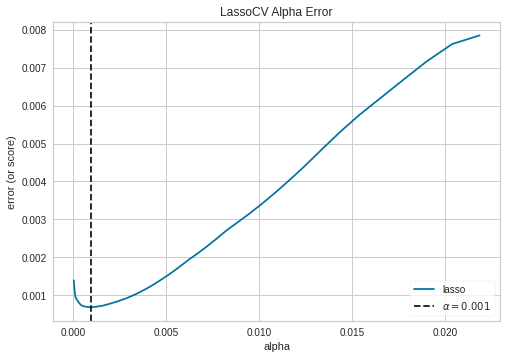

AlphaSelection(ax=<AxesSubplot:title={'center':'LassoCV Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>,
               model=None)

In [500]:
alphas(LassoCV(random_state=0), X_train, y_train)

In [501]:
model = Lasso(alpha=0.001)

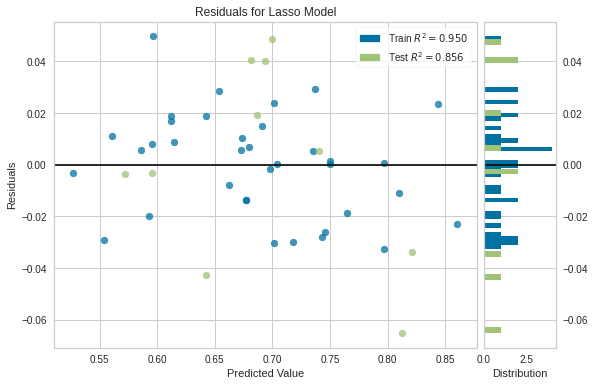

MSE: 0.0013215191339529281, MAE: 0.03691229275542568, R2: 0.8555329034219151


In [502]:
models(model, X_train, X_val, y_train, y_val)

In [148]:
k_vs_score = []
for k in range(2,X_train.shape[1],2):
    select_model = Lasso(alpha=0.002)
    selector = SelectFromModel(select_model, max_features= k, threshold = -np.inf)
    selector.fit(X_train, y_train)
    Xtrain2 = selector.transform(X_train)
    Xval2 = selector.transform(X_val)
    mdl = Lasso(alpha=0.002)
    mdl.fit(Xtrain2,y_train)
    p = mdl.predict(Xval2)
    score = mean_squared_error(y_val,p)
    print("k= {} - MSE = {}".format(k,score))
    k_vs_score.append(score)

k= 2 - MSE = 0.004136772763978365
k= 4 - MSE = 0.0017586774858779606
k= 6 - MSE = 0.0011942147242260833
k= 8 - MSE = 0.0011724800814150228
k= 10 - MSE = 0.001284807827764138
k= 12 - MSE = 0.0012848078277641391
k= 14 - MSE = 0.00128480782776414
k= 16 - MSE = 0.001284807827764138
k= 18 - MSE = 0.0012848078277641385
k= 20 - MSE = 0.001284807827764138
k= 22 - MSE = 0.0012848078277641385
k= 24 - MSE = 0.0012848078277641385
k= 26 - MSE = 0.001284798425272226
k= 28 - MSE = 0.001284798425272226
k= 30 - MSE = 0.001284798425272226
k= 32 - MSE = 0.001284798425272226
k= 34 - MSE = 0.001284798425272226
k= 36 - MSE = 0.001284798425272226
k= 38 - MSE = 0.001284798425272226
k= 40 - MSE = 0.001284798425272226
k= 42 - MSE = 0.001284798425272226
k= 44 - MSE = 0.001284798425272226
k= 46 - MSE = 0.001284798425272226
k= 48 - MSE = 0.001284798425272226
k= 50 - MSE = 0.0012848052456665795
k= 52 - MSE = 0.0012847784015125718
k= 54 - MSE = 0.0012848012396082832


In [57]:
select_model = Lasso(alpha=0.002)
selector = SelectFromModel(select_model, max_features= 7, threshold = -np.inf)
selector.fit(X_train, y_train)
Xtrain2 = selector.transform(X_train)
Xval2 = selector.transform(X_val)
X_train.columns[selector.get_support()]

Index(['algoritmo_aprend_super', 'IC', 'progresso_curso', 'previsao_formacao',
       'ingles_leitura', 'turno_estagio', 'horas_estagio'],
      dtype='object')

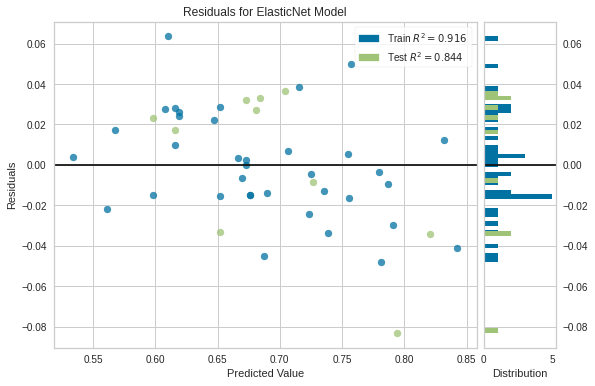

MSE: 0.001427152819901451, MAE: 0.0325722665888693, R2: 0.8439851387942651


In [58]:
models(model, X_train[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]], y_train, y_val)

In [139]:
rfe = RFE(estimator=Lasso(alpha=0.002), n_features_to_select=5)
rfe.fit(X_train, y_train)
for i in range(X_train.shape[1]):
    print('%s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

algoritmo_aprend_super, Selected True, Rank: 1.000
algoritmo_aprend_nao_super, Selected False, Rank: 6.000
algoritmo_aprend_refor, Selected False, Rank: 20.000
algoritmo_aprend_profun, Selected False, Rank: 19.000
algoritmo_modelagem_preditiva, Selected False, Rank: 11.000
algoritmo_modelavem_multivariada, Selected False, Rank: 10.000
algoritmo_visao_computacional, Selected False, Rank: 18.000
algoritmo_pdi, Selected False, Rank: 17.000
algoritmo_pds, Selected False, Rank: 23.000
algoritmo_busca_inteligente, Selected False, Rank: 22.000
algoritmo_otimizacao, Selected False, Rank: 12.000
algoritmo_sist_sugestao, Selected False, Rank: 25.000
algoritmo_robotica, Selected False, Rank: 24.000
tool_python, Selected False, Rank: 29.000
tool_R, Selected False, Rank: 28.000
tool_MATLAB, Selected False, Rank: 16.000
tool_sql, Selected False, Rank: 30.000
tool_dw, Selected False, Rank: 32.000
tool_BD, Selected False, Rank: 34.000
tool_cloud, Selected False, Rank: 36.000
tool_scala, Selected False

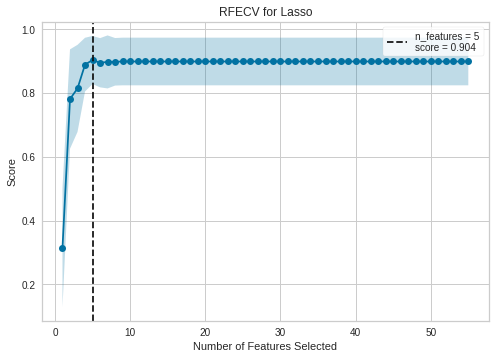

<AxesSubplot:title={'center':'RFECV for Lasso'}, xlabel='Number of Features Selected', ylabel='Score'>

In [140]:
visualizer = RFECV(Lasso(alpha=0.002))
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()

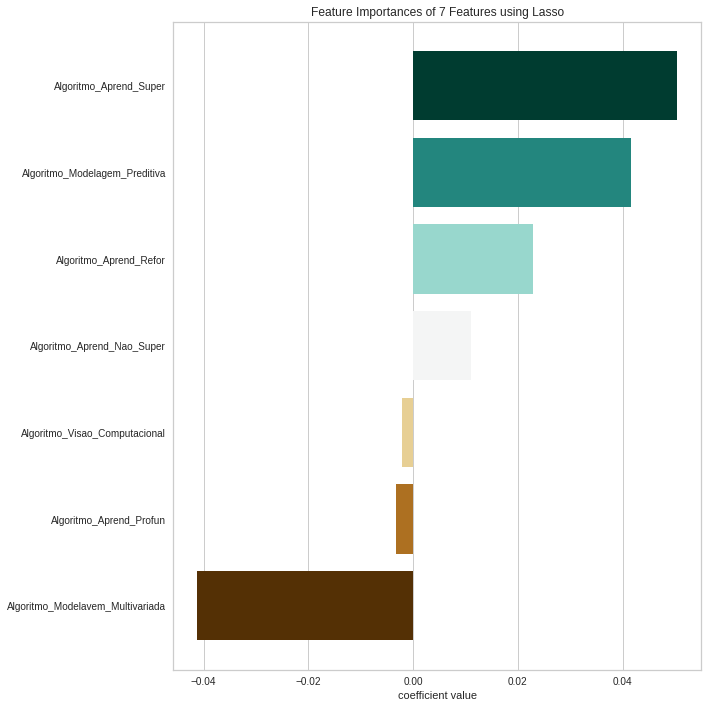

<AxesSubplot:title={'center':'Feature Importances of 7 Features using Lasso'}, xlabel='coefficient value'>

In [128]:
feature_importance(model,X_train,y_train)

**Feature selection com RIDGE**

In [622]:
X_ridge = X

In [219]:
for col in X:
    X_ridge[col] = X_ridge[col].astype('category')

In [623]:
X_ridge = X_ridge.drop('idade',axis=1)

In [214]:
X_ridge = preprocess(X_ridge)

In [624]:
X_train, X_val, y_train, y_val = split(X_ridge, y,0.2)

In [625]:
model = Ridge()

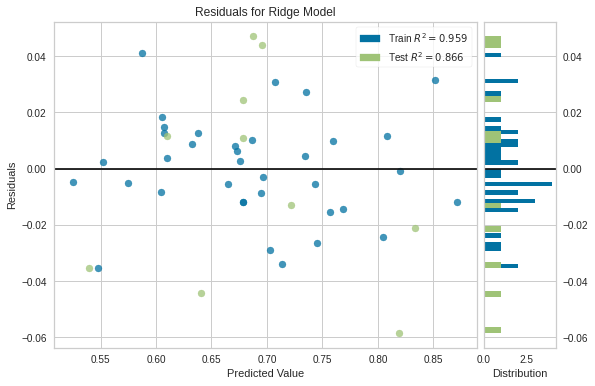

MSE: 0.0012253278515489314, MAE: 0.029867727792827314, R2: 0.8660484343196486


In [626]:
models(model, X_train, X_val, y_train, y_val)

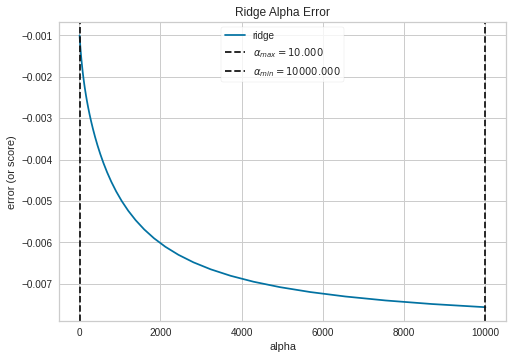

<AxesSubplot:title={'center':'Ridge Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>

In [224]:
alphas = np.logspace(1, 4, 50)

visualizer = ManualAlphaSelection(
    Ridge(),
    alphas=alphas,
    cv=12,
    scoring="neg_mean_squared_error"
)

visualizer.fit(X_train, y_train)
visualizer.show()

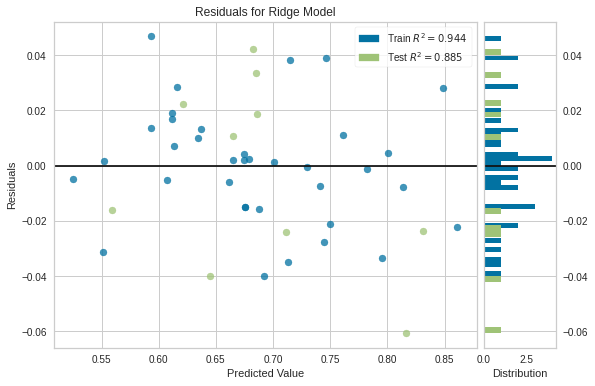

MSE: 0.0010556160483670295, MAE: 0.02376876487552132, R2: 0.8846011520448799


In [629]:
model = Ridge(alpha=5)
models(model, X_train, X_val, y_train, y_val)

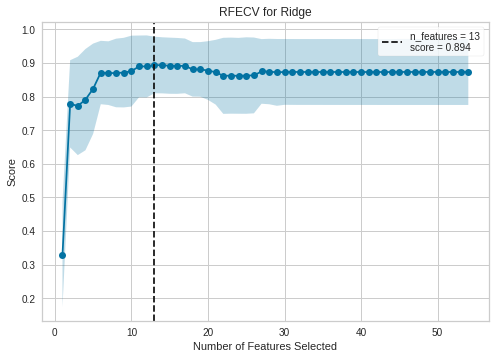

<AxesSubplot:title={'center':'RFECV for Ridge'}, xlabel='Number of Features Selected', ylabel='Score'>

In [226]:
visualizer = RFECV(Ridge(alpha=5))
visualizer.fit(X_train, y_train)        # Fit the data to the visualizer
visualizer.show()

In [239]:
rfe = RFE(estimator=Ridge(alpha=5), n_features_to_select=5)
rfe.fit(X_train, y_train)
for i in range(X_train.shape[1]):
    print('%s, Selected %s, Rank: %.3f' % (X_train.columns[i], rfe.support_[i], rfe.ranking_[i]))

algoritmo_aprend_super, Selected False, Rank: 19.000
algoritmo_aprend_nao_super, Selected False, Rank: 18.000
algoritmo_aprend_refor, Selected False, Rank: 17.000
algoritmo_aprend_profun, Selected False, Rank: 14.000
algoritmo_modelagem_preditiva, Selected False, Rank: 13.000
algoritmo_modelavem_multivariada, Selected False, Rank: 12.000
algoritmo_visao_computacional, Selected False, Rank: 10.000
algoritmo_pdi, Selected False, Rank: 9.000
algoritmo_pds, Selected False, Rank: 8.000
algoritmo_busca_inteligente, Selected False, Rank: 5.000
algoritmo_otimizacao, Selected False, Rank: 3.000
algoritmo_sist_sugestao, Selected True, Rank: 1.000
algoritmo_robotica, Selected True, Rank: 1.000
tool_python, Selected False, Rank: 28.000
tool_R, Selected False, Rank: 26.000
tool_MATLAB, Selected False, Rank: 24.000
tool_sql, Selected False, Rank: 32.000
tool_dw, Selected False, Rank: 31.000
tool_BD, Selected False, Rank: 34.000
tool_cloud, Selected False, Rank: 36.000
tool_scala, Selected False, Ran

In [240]:
k_vs_score = []
for k in range(2,X_train.shape[1],2):
    select_model = Ridge(alpha=5)
    selector = SelectFromModel(select_model, max_features= k, threshold = -np.inf)
    selector.fit(X_train, y_train)
    Xtrain2 = selector.transform(X_train)
    Xval2 = selector.transform(X_val)
    mdl = Ridge(alpha=5)
    mdl.fit(Xtrain2,y_train)
    p = mdl.predict(Xval2)
    score = mean_squared_error(y_val,p)
    print("k= {} - MSE = {}".format(k,score))
    k_vs_score.append(score)

k= 2 - MSE = 0.006878051852154543
k= 4 - MSE = 0.005596998548092823
k= 6 - MSE = 0.005489886709967298
k= 8 - MSE = 0.004696626362728117
k= 10 - MSE = 0.004868147307458448
k= 12 - MSE = 0.00524521493129969
k= 14 - MSE = 0.0011842472610512187
k= 16 - MSE = 0.0010398108406147622
k= 18 - MSE = 0.0010201759568918866
k= 20 - MSE = 0.0010131308790653736
k= 22 - MSE = 0.0010096092795028927
k= 24 - MSE = 0.0010075214972283624
k= 26 - MSE = 0.0010061480254056618
k= 28 - MSE = 0.0009939946225697776
k= 30 - MSE = 0.0010421193532145043
k= 32 - MSE = 0.0010498073788064316
k= 34 - MSE = 0.0010521682415638642
k= 36 - MSE = 0.0010533127748766462
k= 38 - MSE = 0.00105398828610026
k= 40 - MSE = 0.0010544340225077825
k= 42 - MSE = 0.001054750171360114
k= 44 - MSE = 0.0010549860691613376
k= 46 - MSE = 0.0010551688294559284
k= 48 - MSE = 0.0010553145884766861
k= 50 - MSE = 0.0010554335497622383
k= 52 - MSE = 0.001055532481109653


In [643]:
select_model = Ridge(alpha=5)
selector = SelectFromModel(select_model, max_features= 22, threshold = -np.inf)
selector.fit(X_train, y_train)
Xtrain2 = selector.transform(X_train)
Xval2 = selector.transform(X_val)
X_train.columns[selector.get_support()]

Index(['algoritmo_aprend_super', 'algoritmo_aprend_nao_super',
       'algoritmo_aprend_refor', 'algoritmo_aprend_profun',
       'algoritmo_modelagem_preditiva', 'algoritmo_modelavem_multivariada',
       'algoritmo_visao_computacional', 'algoritmo_pdi', 'algoritmo_pds', 'IC',
       'TCC', 'progresso_curso', 'previsao_formacao', 'titulacao',
       'ingles_leitura', 'ingles_escrita', 'ingles_conversa', 'turno_estagio',
       'horas_estagio', 'grande_vitoria', 'trab_presencial',
       'primeira_graduacao'],
      dtype='object')

In [644]:
model = RidgeCV()

In [648]:
model = Ridge(alpha=4)

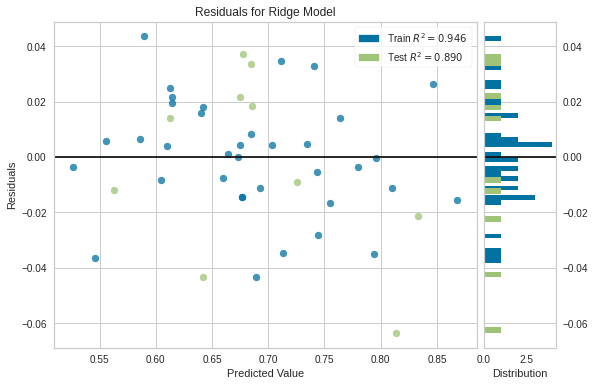

MSE: 0.001008073646830858, MAE: 0.021457197653285964, R2: 0.8897984379091682


In [649]:
models(model, X_train[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]], y_train, y_val)

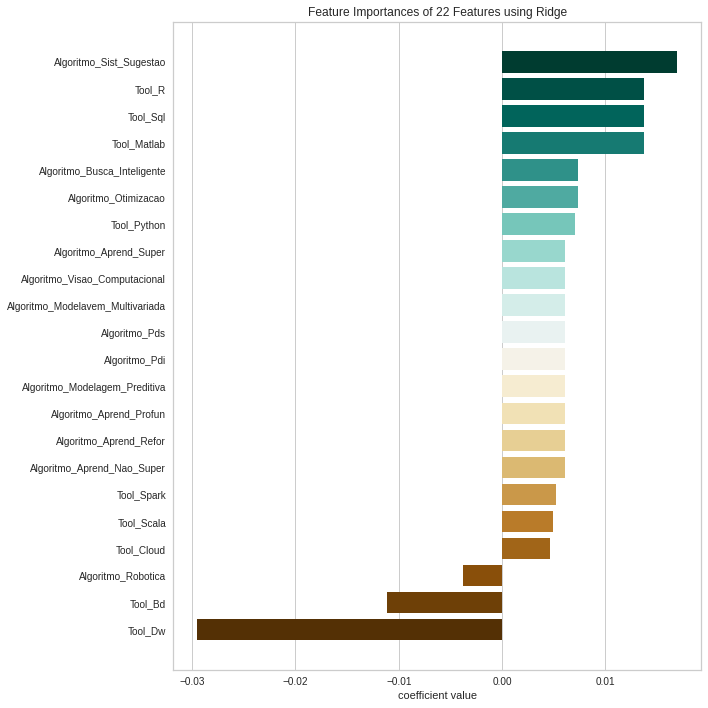

<AxesSubplot:title={'center':'Feature Importances of 22 Features using Ridge'}, xlabel='coefficient value'>

In [650]:
feature_importance(model,X_train,y_train)

**Feature selection com ElasticNet**

In [608]:
X_elastic = X

In [443]:
for col in X:
    X_elastic[col] = X_elastic[col].astype('category')

In [609]:
X_elastic = X_elastic.drop('idade',axis=1)

In [259]:
X_elastic = preprocess(X_elastic)

In [610]:
X_train, X_val, y_train, y_val = split(X_elastic,y,0.2)

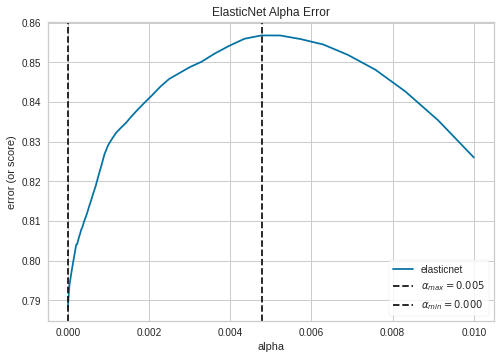

ManualAlphaSelection(alphas=array([1.00000000e-10, 1.09698580e-10, 1.20337784e-10, 1.32008840e-10,
       1.44811823e-10, 1.58856513e-10, 1.74263339e-10, 1.91164408e-10,
       2.09704640e-10, 2.30043012e-10, 2.52353917e-10, 2.76828663e-10,
       3.03677112e-10, 3.33129479e-10, 3.65438307e-10, 4.00880633e-10,
       4.39760361e-10, 4.82410870e-10, 5.29197874e-10, 5.80522552e-10,
       6.36824994e-10,...
       1.72258597e-03, 1.88965234e-03, 2.07292178e-03, 2.27396575e-03,
       2.49450814e-03, 2.73644000e-03, 3.00183581e-03, 3.29297126e-03,
       3.61234270e-03, 3.96268864e-03, 4.34701316e-03, 4.76861170e-03,
       5.23109931e-03, 5.73844165e-03, 6.29498899e-03, 6.90551352e-03,
       7.57525026e-03, 8.30994195e-03, 9.11588830e-03, 1.00000000e-02]),
                     ax=<AxesSubplot:title={'center':'ElasticNet Alpha Error'}, xlabel='alpha', ylabel='error (or score)'>,
                     model=None)

In [611]:
model = ElasticNet(tol=0.01, max_iter=10000)

# Use the quick method and immediately show the figure
manual_alphas(model, X_train, y_train, cv=6)

In [618]:
model = ElasticNet(alpha=0.002, tol=0.01, max_iter=10000)

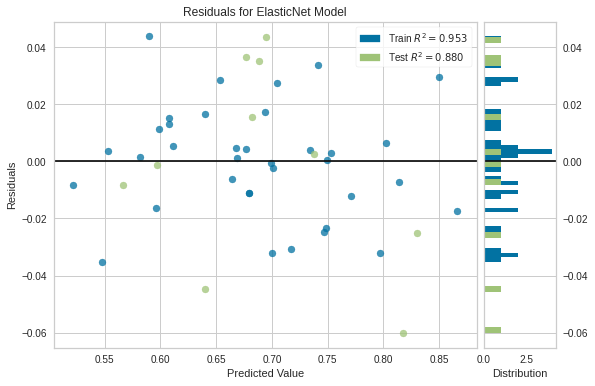

MSE: 0.0011014772009138984, MAE: 0.0300274957546946, R2: 0.8795876585706289


In [619]:
models(model, X_train, X_val, y_train, y_val)

In [601]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# define model
ratios = np.arange(0, 1, 0.01)
alphas = np.arange(0.001,0.01,0.001)
model = ElasticNetCV(l1_ratio=ratios, alphas=alphas, cv=cv, n_jobs=-1, tol = 0.01, max_iter = 50000)
# fit model
model.fit(X_train, y_train)
# summarize chosen configuration
print('alpha: %f' % model.alpha_)
print('l1_ratio_: %f' % model.l1_ratio_)

alpha: 0.002000
l1_ratio_: 0.930000


In [604]:
metrics(model,y_val,model.predict(X_val))

MSE: 0.0011517144861881697, MAE: 0.03107882692653724, R2: 0.8740957708203321


In [606]:
model = ElasticNet(alpha=0.002, l1_ratio=0.19, max_iter=50000,tol=0.01)

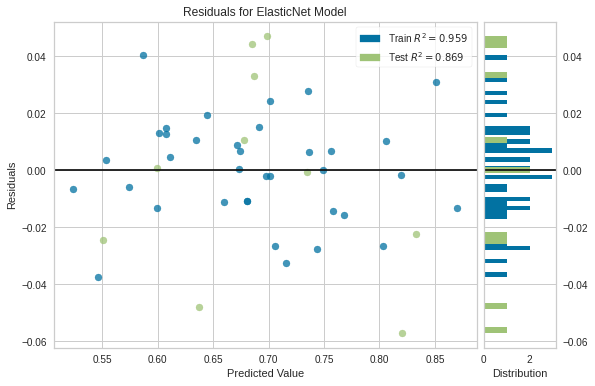

MSE: 0.0012018014178232436, MAE: 0.028855297715249584, R2: 0.8686203195734175


In [607]:
models(model, X_train, X_val, y_train, y_val)

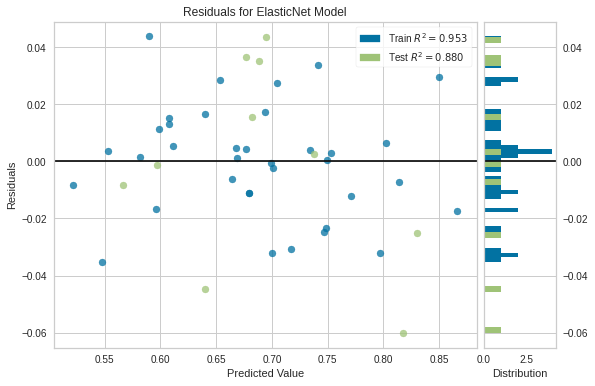

MSE: 0.0011013242170136435, MAE: 0.030032332995265087, R2: 0.8796043826114128


In [621]:
models(model, X_train[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]], y_train, y_val)

**Feature selection**

In [620]:
select_model = ElasticNet(alpha=0.002, tol=0.01, max_iter=10000)
selector = SelectFromModel(select_model, max_features= 22, threshold = -np.inf)
selector.fit(X_train, y_train)
Xtrain2 = selector.transform(X_train)
Xval2 = selector.transform(X_val)
X_train.columns[selector.get_support()]

Index(['algoritmo_aprend_super', 'algoritmo_aprend_nao_super',
       'algoritmo_aprend_refor', 'algoritmo_aprend_profun',
       'algoritmo_modelagem_preditiva', 'algoritmo_modelavem_multivariada',
       'algoritmo_visao_computacional', 'algoritmo_pdi', 'algoritmo_pds',
       'algoritmo_otimizacao', 'IC', 'TCC', 'progresso_curso',
       'previsao_formacao', 'curso', 'ingles_vivencia_ext', 'ingles_leitura',
       'ingles_escrita', 'ingles_conversa', 'turno_estagio', 'horas_estagio',
       'primeira_graduacao'],
      dtype='object')

**Testando outros modelos**

In [430]:
X_train, X_val, y_train, y_val = split(X,y,0.2)

In [459]:
model = LinearSVR()

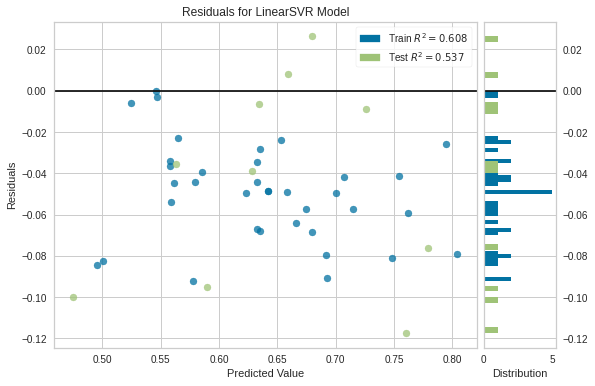

MSE: 0.004231345688113437, MAE: 0.03704816248336029, R2: 0.5374336924267941


In [460]:
models(model,X_train, X_val, y_train, y_val)

In [468]:
model = linear_model.BayesianRidge()

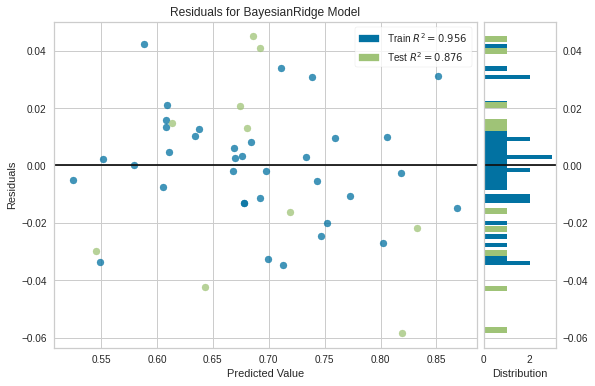

MSE: 0.0011353767056080156, MAE: 0.02584163444669285, R2: 0.8758817999925959


In [469]:
models(model,X_train, X_val, y_train, y_val)

In [491]:
model = linear_model.SGDRegressor()

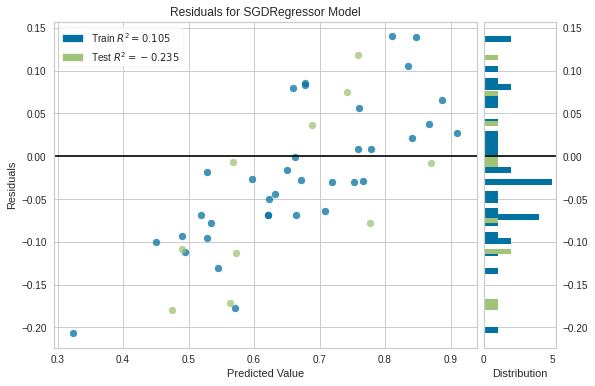

MSE: 0.011292875601194883, MAE: 0.09305941286289607, R2: -0.23452540958837975


In [492]:
models(model,X_train, X_val, y_train, y_val)

In [485]:
model = linear_model.LassoLarsCV()

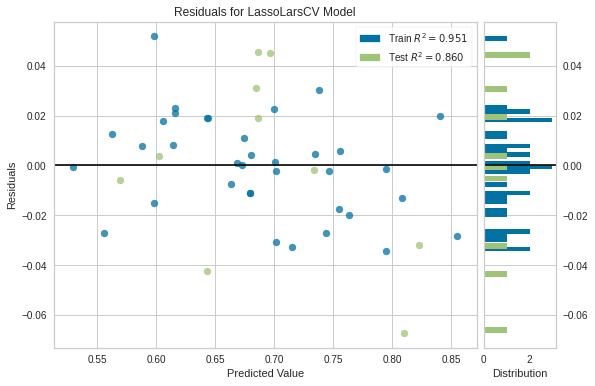

MSE: 0.0012827664573891397, MAE: 0.03150486437489197, R2: 0.8597693056986297


In [486]:
models(model,X_train, X_val, y_train, y_val)

## Modelagem para ALGORITMO

https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

In [512]:
df = pd.read_csv('data/preprocess.csv')
notas = pd.read_csv('data/notas_candidatos.csv')

In [513]:
df_merge = pd.merge(df,notas,how='left',on='nome')

In [514]:
df_train = df_merge[df_merge['aprovado'] !='?']
X_new = df_train.filter(regex='algo').drop('nota_algoritmos',axis=1)
y_new = df_train['nota_algoritmos']

In [373]:
for col in X:
    X_new[col] = X_new[col].astype('category')

In [365]:
X_new = X_new.sum(axis=1).to_frame()

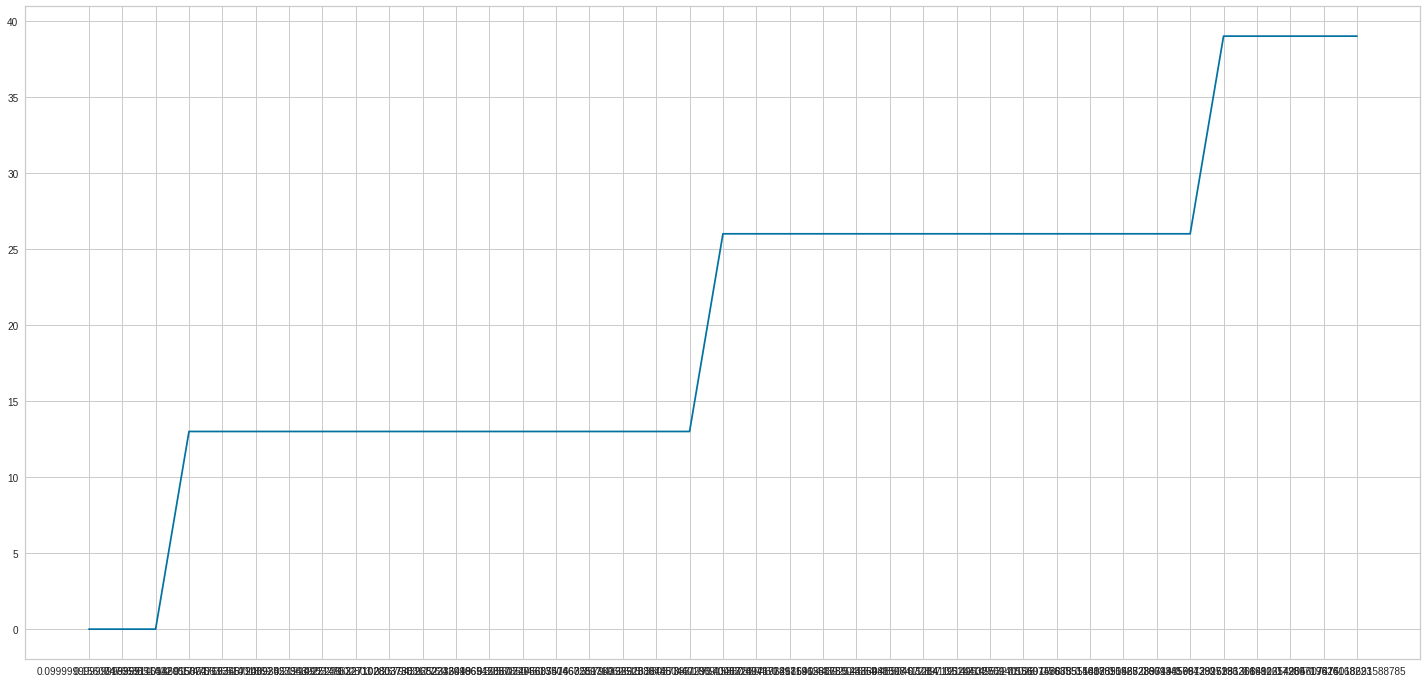

In [366]:
plt.figure(figsize=(25,12))
plt.plot(y.sort_values(),X_new.iloc[:,0].sort_values())

In [517]:
X_train, X_val, y_train, y_val = split(X_new,y_new,0.2)

In [523]:
X_train.columns

Index(['algoritmo_aprend_super', 'algoritmo_aprend_nao_super',
       'algoritmo_aprend_refor', 'algoritmo_aprend_profun',
       'algoritmo_modelagem_preditiva', 'algoritmo_modelavem_multivariada',
       'algoritmo_visao_computacional', 'algoritmo_pdi', 'algoritmo_pds',
       'algoritmo_busca_inteligente', 'algoritmo_otimizacao',
       'algoritmo_sist_sugestao', 'algoritmo_robotica'],
      dtype='object')

In [518]:
model = ElasticNetCV()

In [369]:
model = RandomForestRegressor()

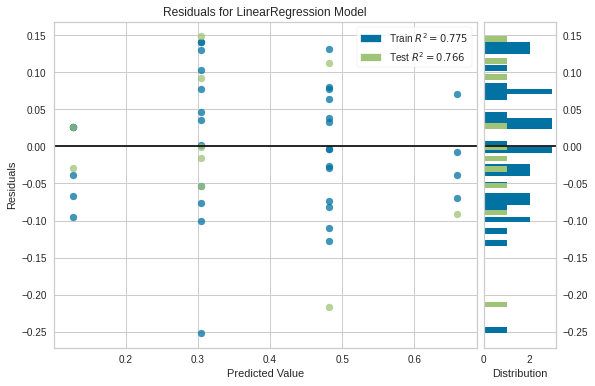

MSE: 0.010347796332177523, MAE: 0.0726815240833932, R2: 0.7661179561976247


In [532]:
models(model, X_train, X_val, y_train, y_val)

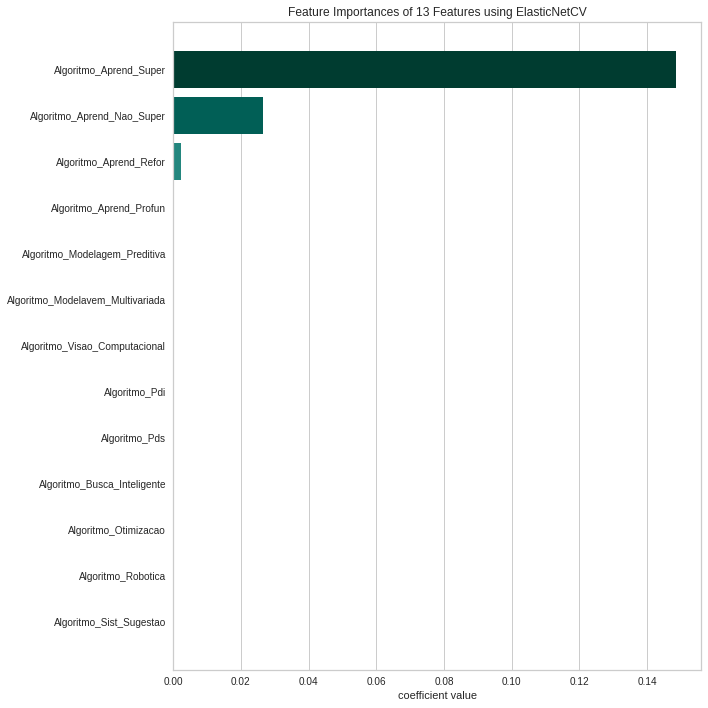

<AxesSubplot:title={'center':'Feature Importances of 13 Features using ElasticNetCV'}, xlabel='coefficient value'>

In [383]:
feature_importance(model,X_train,y_train)

In [194]:
df_train = df_merge[df_merge['aprovado'] !='?']
X = df_train.filter(regex='tool')
y = df_train['nota_ferramentas']

**Smote**

In [24]:
import smote
from imblearn.over_sampling import SMOTE

In [25]:
X_smote = X

In [20]:
for col in X:
    X_smote[col] = X_smote[col].astype('category')

In [26]:
X_smote = X_smote.drop('idade',axis=1)

In [22]:
X_smote = preprocess(X_smote)

In [27]:
X_train, X_val, y_train, y_val = split(X_smote, y,0.2)

In [63]:
rdover = RandomOverSampler(random_state = 101)

In [64]:
X_oversample_ada, y_oversample_ada = rdover.fit_resample(X_train, y_train)

In [66]:
model = Ridge(alpha=5)

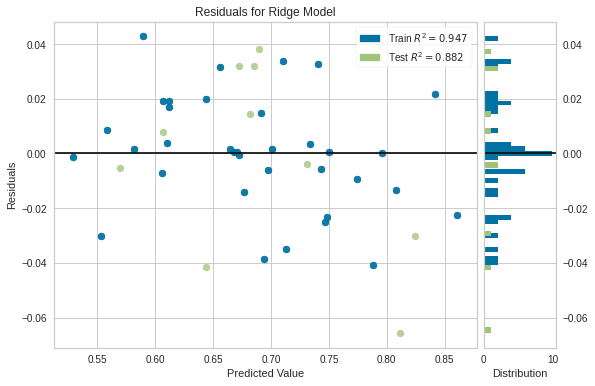

MSE: 0.001076332940620275, MAE: 0.031062797957690902, R2: 0.8823364029413274


In [72]:
models(model,X_oversample_ada[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]],y_oversample_ada,y_val)

**TPOT**

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75, test_size=0.25)

pipeline_optimizer = TPOTRegressor(generations=5, population_size=100, cv=2,
                                    random_state=42, verbosity=2)
pipeline_optimizer.fit(X_train, y_train)
print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.export('tpot_exported_pipeline.py')

Version 0.11.6.post2 of tpot is outdated. Version 0.11.6.post3 was released 1 day ago.


                                                                              
Generation 1 - Current best internal CV score: -0.008532591633709365
                                                                              
Generation 2 - Current best internal CV score: -0.007909215763312601
                                                                              
Generation 3 - Current best internal CV score: -0.007909215763312601
                                                                              
Generation 4 - Current best internal CV score: -0.007811119209895917
                                                                              
Generation 5 - Current best internal CV score: -0.007811119209895917
                                                                              
Best pipeline: LinearSVR(input_matrix, C=1.0, dual=True, epsilon=0.0001, loss=epsilon_insensitive, tol=0.01)
-0.008212641088146256


In [393]:
metrics(model,y_test,pipeline_optimizer.predict(X_test))

MSE: 0.008212641088146256, MAE: 0.08599951568899292, R2: 0.45104394237511114


## Modelo Final

Ridge com alpha 5

In [108]:
X_ridge = X

In [97]:
for col in X:
    X_ridge[col] = X_ridge[col].astype('category')

In [109]:
X_ridge = X_ridge.drop('idade',axis=1)

In [99]:
X_ridge = preprocess(X_ridge)

In [110]:
X_train, X_val, y_train, y_val = split(X_ridge, y,0.2)

In [111]:
select_model = Ridge(alpha=5)
selector = SelectFromModel(select_model, max_features= 22, threshold = -np.inf)
selector.fit(X_train, y_train)
Xtrain2 = selector.transform(X_train)
Xval2 = selector.transform(X_val)
X_train.columns[selector.get_support()]

Index(['algoritmo_aprend_super', 'algoritmo_aprend_nao_super',
       'algoritmo_aprend_refor', 'algoritmo_aprend_profun',
       'algoritmo_modelagem_preditiva', 'algoritmo_modelavem_multivariada',
       'algoritmo_visao_computacional', 'algoritmo_pdi', 'algoritmo_pds', 'IC',
       'TCC', 'progresso_curso', 'previsao_formacao', 'titulacao',
       'ingles_leitura', 'ingles_escrita', 'ingles_conversa', 'turno_estagio',
       'horas_estagio', 'grande_vitoria', 'trab_presencial',
       'primeira_graduacao'],
      dtype='object')

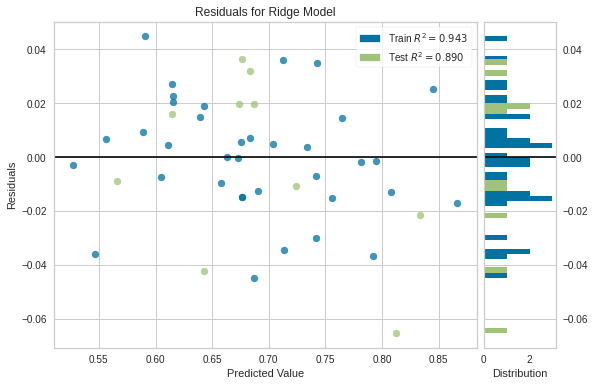

MSE: 0.0010096092795028927, MAE: 0.020663519964800647, R2: 0.8896305641434092


In [112]:
model = Ridge(alpha=5)
models(model, X_train[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]], y_train, y_val)

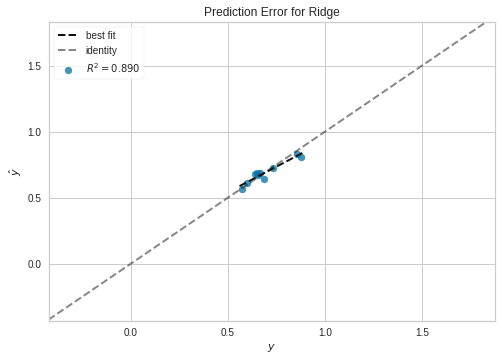

In [123]:
error(model, X_train[X_train.columns[selector.get_support()]], X_val[X_train.columns[selector.get_support()]], y_train, y_val)

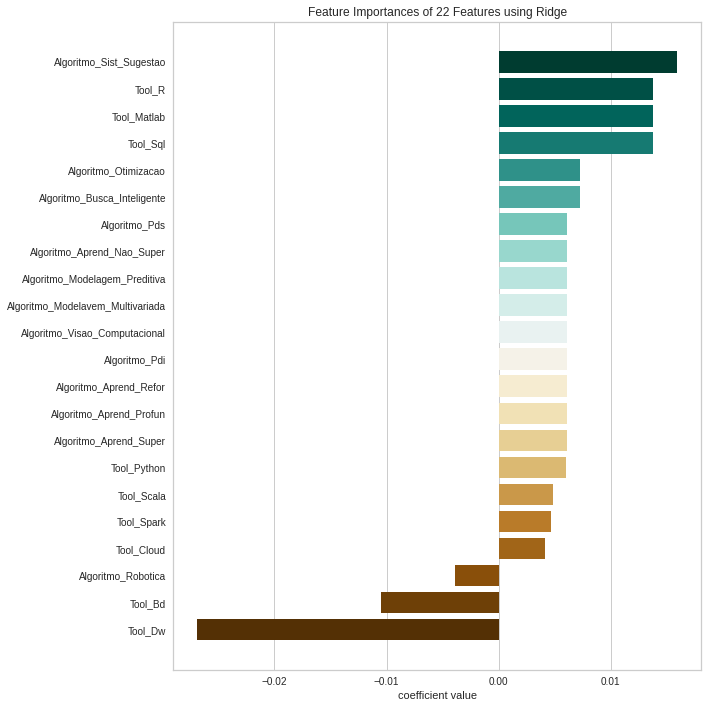

In [124]:
feature_importance(model,X_train,y_train);

In [125]:
predict = model.predict(df_teste[X_train.columns[selector.get_support()]])

In [126]:
predicts = pd.DataFrame(predict>0.7,columns=['aprovado'])

In [127]:
aux = df_teste[['id_candidato','nome']].reset_index().drop('index',axis=1)

In [128]:
resultado = pd.concat([aux,predicts],axis=1,ignore_index=False)

In [129]:
predict

array([0.87833277, 0.67213822, 0.50572814, 0.70441664, 0.60049209,
       0.75202539])

In [132]:
resultado.to_csv('data/resultado.csv',header=True,index=False)